The experiment of BBI onto MNIST dataset with different architectures.

The main idea is to add a one conv layer every time when we launch new check episode.

In [1]:
import torch 
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
from inflation import BBI

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist/', train=False, download=True, transform=transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [34]:
class Net(nn.Module):
    def __init__(self, n_hidden = 2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.layers = []
        self.layers += [self.conv1, self.relu, self.pool, self.conv2, self.relu]
        in_chan = 32
        if n_hidden > 2:
            for i in range(n_hidden - 2):
                self.conv = nn.Conv2d(in_channels=in_chan, out_channels=in_chan*2, kernel_size=3, padding=1)
                self.layers += [self.conv, self.relu]
                in_chan = in_chan*2
        self.layers += [self.pool]
        self.net = nn.Sequential(*self.layers)
        self.fc1 = nn.Linear(in_features=in_chan*7*7, out_features=120)
        
    def forward(self, x):
        x = self.net(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        return x

Without adding layers

In [5]:
# Train
model = Net(2).to(device)
criterion = nn.CrossEntropyLoss()

epochs = 10
v0 = 1e-6
threshold0 = 100
n_fixed_bounces = 5
threshold = 1000
n_check = 5

optimizer = BBI(model.parameters(), lr=0.2, deltaEn = 1.0, v0 = v0, threshold0 = threshold0, threshold = threshold, n_fixed_bounces = n_fixed_bounces)

tests_loss = []
for k in range(n_check):
    print(f'Run: {k+1}')
    for epoch in range(1, epochs+1):
        loss_tr = 0.0
        test = []
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            def closure(): return loss 
            optimizer.step(closure)
            loss_tr += loss.item()
        
        if epoch%2 == 0: print(f'\tEpoch {epoch}, \tavrg. loss: ', loss_tr / len(train_loader))
        tests_loss.append(loss_tr / len(train_loader))

        # Evaluate for each epoch
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        if epoch%2 == 0: print(f'\tEpoch {epoch} \t Accuracy: {100 * correct / total}')
        test.append(correct/total)

Run: 1
	Epoch 2, 	avrg. loss:  0.06487054339458191
	Epoch 2 	 Accuracy: 98.66
	Epoch 4, 	avrg. loss:  0.03445890884094062
	Epoch 4 	 Accuracy: 98.73
	Epoch 6, 	avrg. loss:  0.02128957494346228
	Epoch 6 	 Accuracy: 99.14
	Epoch 8, 	avrg. loss:  0.012079517182172166
	Epoch 8 	 Accuracy: 99.3
	Epoch 10, 	avrg. loss:  0.008204581163444628
	Epoch 10 	 Accuracy: 99.22
Run: 2
	Epoch 2, 	avrg. loss:  0.006128318684501279
	Epoch 2 	 Accuracy: 99.33
	Epoch 4, 	avrg. loss:  0.004351816756905877
	Epoch 4 	 Accuracy: 99.25
	Epoch 6, 	avrg. loss:  0.003268983249184481
	Epoch 6 	 Accuracy: 99.25
	Epoch 8, 	avrg. loss:  0.002425500393307582
	Epoch 8 	 Accuracy: 99.31
	Epoch 10, 	avrg. loss:  0.001961424563659917
	Epoch 10 	 Accuracy: 99.29
Run: 3
	Epoch 2, 	avrg. loss:  0.0014574369977934886
	Epoch 2 	 Accuracy: 99.31
	Epoch 4, 	avrg. loss:  0.0011199044864375856
	Epoch 4 	 Accuracy: 99.36
	Epoch 6, 	avrg. loss:  0.000802118777237206
	Epoch 6 	 Accuracy: 99.29
	Epoch 8, 	avrg. loss:  0.000673722198918

In [35]:
criterion = nn.CrossEntropyLoss()

# Train
epochs = 10
v0 = 1e-6
threshold0 = 100
n_fixed_bounces = 5
threshold = 1000
n_check = 5
tests_loss_new = []
for k in range(n_check):
    print(f'Run: {k+1} \t# of conv. layers: {2+k}')
    model = Net(2 + k).to(device)
    optimizer = BBI(model.parameters(), lr=0.2, deltaEn = 1.0, v0 = v0, threshold0 = threshold0, threshold = threshold, n_fixed_bounces = n_fixed_bounces)

    for epoch in range(1, epochs+1):
        loss_tr = 0.0
        test = []
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            def closure(): return loss 
            optimizer.step(closure)
            loss_tr += loss.item()
        if epoch%2 == 0: print(f'\tEpoch {epoch}, \tavrg. loss: ', loss_tr / len(train_loader))
        tests_loss_new.append(loss_tr / len(train_loader))

        # Evaluate
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        if epoch%2 == 0: print(f'\tEpoch {epoch} \t Accuracy: {100 * correct / total}')
        test.append(correct/total)

Run: 1 	# of conv. layers: 2
	Epoch 2, 	avrg. loss:  0.06426373033595124
	Epoch 2 	 Accuracy: 98.17
	Epoch 4, 	avrg. loss:  0.03698173857828651
	Epoch 4 	 Accuracy: 98.73
	Epoch 6, 	avrg. loss:  0.0230199791727534
	Epoch 6 	 Accuracy: 98.94
	Epoch 8, 	avrg. loss:  0.014104531379921539
	Epoch 8 	 Accuracy: 99.1
	Epoch 10, 	avrg. loss:  0.009323428860247911
	Epoch 10 	 Accuracy: 99.21
Run: 2 	# of conv. layers: 3
	Epoch 2, 	avrg. loss:  0.20045167263741218
	Epoch 2 	 Accuracy: 96.38
	Epoch 4, 	avrg. loss:  0.12813482028586087
	Epoch 4 	 Accuracy: 96.98
	Epoch 6, 	avrg. loss:  0.1080849361621456
	Epoch 6 	 Accuracy: 97.23
	Epoch 8, 	avrg. loss:  0.07746171416398585
	Epoch 8 	 Accuracy: 98.14
	Epoch 10, 	avrg. loss:  0.06148562432722836
	Epoch 10 	 Accuracy: 98.23
Run: 3 	# of conv. layers: 4
	Epoch 2, 	avrg. loss:  0.192361464625153
	Epoch 2 	 Accuracy: 93.67
	Epoch 4, 	avrg. loss:  0.165458896091885
	Epoch 4 	 Accuracy: 95.82
	Epoch 6, 	avrg. loss:  0.1329773786633627
	Epoch 6 	 Accuracy

In [49]:
criterion = nn.CrossEntropyLoss()

# Train
epochs = 5
v0 = 1e-6
threshold0 = 100
n_fixed_bounces = 5
threshold = 1000
n_check = 6
test_loss_BBI = []
test = []
for k in range(n_check):
    print(f'Run: {k+1} \t# of conv. layers: {2+k}')
    model = Net(2 + k).to(device)
    optimizer = BBI(model.parameters(), lr=0.2, deltaEn = 1.0, v0 = v0, threshold0 = threshold0, threshold = threshold, n_fixed_bounces = n_fixed_bounces)

    for epoch in range(1, epochs+1):
        loss_tr = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            def closure(): return loss 
            optimizer.step(closure)
            loss_tr += loss.item()
    
    # Evaluate
    correct = 0
    total = 0
    loss_tr = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_tr += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_loss_BBI.append(loss_tr/len(test_loader))
    test.append(correct/total)

Run: 1 	# of conv. layers: 2
Run: 2 	# of conv. layers: 3
Run: 3 	# of conv. layers: 4
Run: 4 	# of conv. layers: 5
Run: 5 	# of conv. layers: 6
Run: 6 	# of conv. layers: 7


In [ ]:
test_loss_BBI

In [44]:
criterion = nn.CrossEntropyLoss()

# Train
epochs = 5
n_check = 6
test_loss_Adam = []
test = []
for k in range(n_check):
    print(f'Run: {k+1} \t# of conv. layers: {2+k}')
    model = Net(2 + k).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, epochs+1):
        loss_tr = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() 
            optimizer.step()
            loss_tr += loss.item()
    
    # Evaluate
    correct = 0
    total = 0
    loss_tr = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_tr += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_loss_Adam.append(loss_tr/len(test_loader))
    test.append(correct/total)

Run: 1 	# of conv. layers: 2
Run: 2 	# of conv. layers: 3
Run: 3 	# of conv. layers: 4
Run: 4 	# of conv. layers: 5
Run: 5 	# of conv. layers: 6
Run: 6 	# of conv. layers: 7


In [57]:
criterion = nn.CrossEntropyLoss()

# Train
epochs = 5
n_check = 6
test_loss_SGD = []
test = []
for k in range(n_check):
    print(f'Run: {k+1} \t# of conv. layers: {2+k}')
    model = Net(2 + k).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for epoch in range(1, epochs+1):
        loss_tr = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() 
            optimizer.step()
            loss_tr += loss.item()
    
    # Evaluate
    correct = 0
    total = 0
    loss_tr = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_tr += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_loss_SGD.append(loss_tr/len(test_loader))
    test.append(correct/total)

Run: 1 	# of conv. layers: 2
Run: 2 	# of conv. layers: 3
Run: 3 	# of conv. layers: 4
Run: 4 	# of conv. layers: 5
Run: 5 	# of conv. layers: 6
Run: 6 	# of conv. layers: 7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


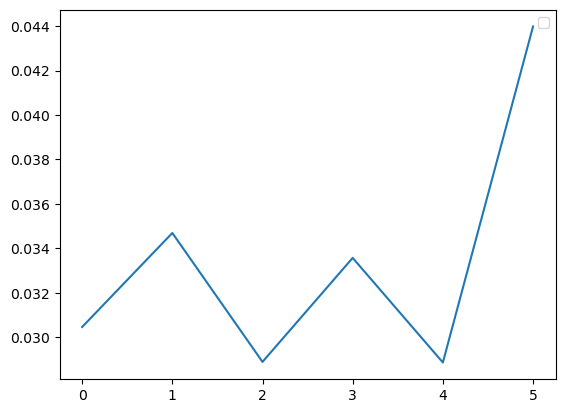

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

t = np.arange(2, 8)

sns.lineplot(y=test_loss_BBI, x=t, label='BBI')
sns.lineplot(y=test_loss_Adam, x=t, label='Adam')
sns.lineplot(y=test_loss_SGD, x=t, label='SGD')

# plt.title('Comparing performance of different architeture.')
plt.xlabel('# of hidden conv. layers')
plt.ylabel('loss')

plt.legend()
plt.show()

The new dataset 

In [ ]:
train_dataset = datasets.ImageNet('image_net/', train=True, download=True, transform=transform)
test_dataset = datasets.ImageNet('image_net/', train=False, download=True, transform=transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)